<a href="https://colab.research.google.com/github/MJMortensonWarwick/ADA2425/blob/main/4_1_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering in Practice
This Notebook will work through several things:


1.   Implementing clustering in Python;
2.   Evaluating the performance of a clustering model (and selecting $K$ for a clustering model);
3. A clustering exercise.

All of this will be built out of our previous stack of _Pandas_, _scikit-lean_ and related libraries. We'll being by implementing the models.
<br><br>
## Implementing Clustering in Python
Let's begin with some data generation:



In [1]:
import numpy as np

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN
from sklearn.datasets import make_blobs

# create three different cluster centres (i.e. K=3)
# note this is 2D data X1 and X2
centers = [[3, 2], [-3, -2], [-2, -1]]

# creating some transformation variables to make the shape anisotropic
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

# create 1500 sample
n_samples = 1500

# build the data - we use y to retain the "true" cluster centre
X, y = make_blobs(n_samples=n_samples, random_state=170)

# transform the data
X = np.dot(X, transformation)  # Anisotropic blobs

We have created some data - let's visually inspect it:

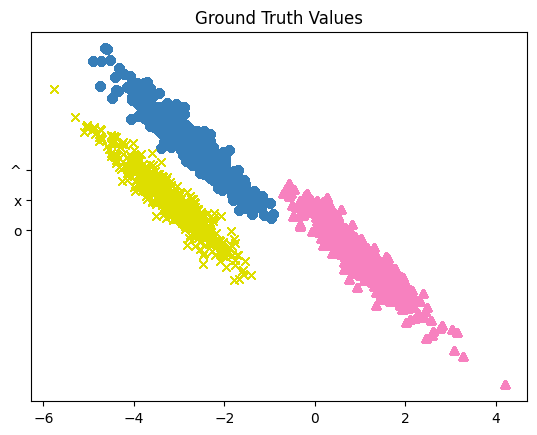

In [2]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

for k in y:
    my_members = y == k
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=colors[k])
    plt.plot(
        markers[k],
        markerfacecolor=colors[k],
        markersize=14,
    )
plt.title("Ground Truth Values")
plt.show()

The same blobs we saw in the lecture.

Now let's fit the first model.
<br><br>
### $K$-means Clustering

In [3]:
# specify the Kmeans algorithm with K (hyperparameter) as 3
km = KMeans(n_clusters=3, random_state=42)

# fit to the data
kmfit = km.fit(X)

# find the cluster labels
kmlabels = kmfit.labels_
print(kmlabels)

# find the cluster centroids
kmout = kmfit.cluster_centers_
print(kmout)

[0 0 2 ... 1 2 1]
[[-3.32167655  3.12504668]
 [ 1.02640439 -0.91883122]
 [-2.62299803  0.85484514]]


The first part (_kmlabels_) is the assignment of a label for each datapoint (i.e. the first two datapoints are labelled as 0).

The second part shows the three cluster's centroid points (X1 and X2).

While we don't have any ground truth metrics here (some other metrics later), we can visualise the data (don't worry about the code its just for the visualisation):

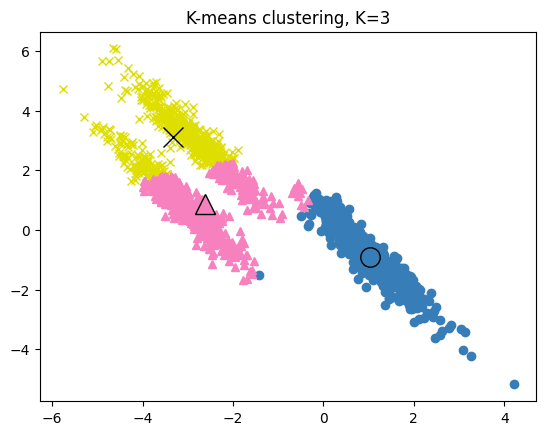

In [4]:
plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

for k, col in zip(range(3), colors):
    my_members = kmlabels == k
    cluster_center = kmout[k]
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("K-means clustering, K=3")
plt.show()

Not ideal probably. In the real world - with real data - we can assess the column means to see what each cluster "means". I.e. if X1 were age this would be the average of the cluster:

In [5]:
import pandas as pd
df_km = pd.DataFrame({'Cluster': [i for i in range(kmfit.n_clusters)], 'X1': [i[0] for i in kmout], 'X2': [i[1] for i in kmout]})
df_km

,Cluster,X1,X2
0,0,-3.321677,3.125047
1,1,1.026404,-0.918831
2,2,-2.622998,0.854845


This code may be a bit intimidating so we'll break it down.

The dataframe is basically a dictionary with three items. The first is the clusters. "kmfit.n_clusters" is the number of clusters (for this model k=3). We ask for "i for i in range(kmfit.n_clusters). This means we ask for every "i" between 0 (as no starting point is specified) and k (which is 3). This gives us the values 0, 1 and 2 as per the dataframe.

The second and third parts do a similar for loop through "kmout". This was the variabke we created earlier to store the co-ordinates of each cluster centroid. For the middle columns ("X1") we want the first item in each list ("i[0]") and for the last ("X2") we take the seond ("i[1]").

As before, we now have the average for X1 and X2 for each cluster. Not massively useful for our fake data, but if these features are meaningful in a business sense (e.g. "age" and "salary") we can start to interpret who is in each cluster and also how useful our model will be. (If we easily understand the label of the cluster it is useful to us - we know how to market, etc.).

We'll come back to look at metrics, but for know lets move on to the next.
<br><br>
### Hierarchical Clustering (Agglomerative)
Here we will build a hierarchical model using the bottom up appraoch (agglomerative). We start by specifying the algorithm:

In [6]:
# set with k=3
ward = AgglomerativeClustering(linkage="ward", n_clusters=3)

wardfit = ward.fit(X)

wardlabels = wardfit.labels_
print(wardlabels)

[0 0 2 ... 1 1 1]


Note we have no centroids in this model, but again have the labels - which look similar to k-means. Let's visualise again:

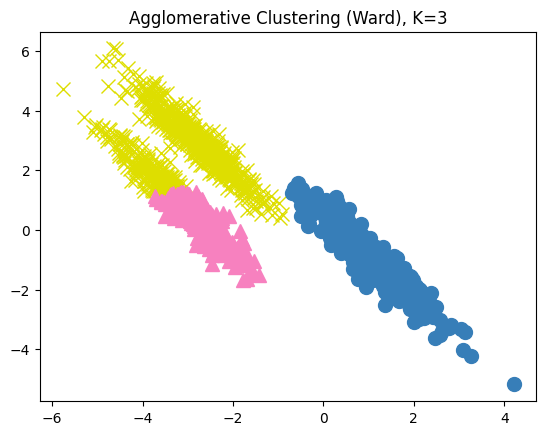

In [7]:
n_clusters_ = len(set(wardlabels)) - (1 if -1 in wardlabels else 0)

import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf", ""]
markers = ["x", "o", "^", ""]

unique_labels = np.unique(wardlabels)
core_samples_mask = np.zeros_like(wardlabels, dtype=bool)

#colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k in unique_labels:
    if k == 0:
        col = "#dede00"
        markers = "x"
    elif k == 1:
        col = "#377eb8"
        markers = "o"
    elif k == 2:
        col = "#f781bf"
        markers = "^"

    # The original code incorrectly used the DBSCAN labels.
    # Changed to the HDBSCAN labels for correct plotting
    class_member_mask = wardlabels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        markers,
        markerfacecolor=col,
        markeredgecolor=col,
        markersize=10,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        markers,
        markerfacecolor=col,
        markeredgecolor=col,
        markersize=10,
    )

plt.title(f"Agglomerative Clustering (Ward), K={n_clusters_}")
plt.show()

Slightly differs from $K$-means but similar. We don't have the centroids but we can calculate averages using pandas:

In [8]:
# add the data
df_ward = pd.DataFrame(X, columns=['X1', 'X2'])
# add the labels
df_ward['ward_label'] = wardlabels

df_ward.head()


,X1,X2,ward_label
0,-3.424694,3.856715,0
1,-3.670550,4.019227,0
2,-3.508982,0.465036,2
3,-2.453220,2.227331,0
4,-2.156954,2.274100,0


Now we can use group_by to work out averages:

In [9]:
# group by label
df_ward_grouped = df_ward.groupby('ward_label').mean()
df_ward_grouped =  df_ward_grouped.reset_index()
df_ward_grouped


,ward_label,X1,X2
0,0,-3.102853,2.658291
1,1,0.996868,-0.870749
2,2,-2.719634,0.316993


At this stage, if X1 and X2 were meaningful, we can compare the two dataframes ("df\_ward\_grouped" and "df\_km") and see which is most interpetable.

Instead let's move to the next algorithm:
<br><br>
### DBSCAN
We will specify DBSCAN with its two important hyperparameters (the distance hyperparameter ($ϵ$ - epsilon) and the minimum number of neighbours for core points) based on aribtrary choices. (In the real-world we need to experiment with them).

In [10]:
dbs = DBSCAN(eps=0.3, min_samples=4)

dbsfit = dbs.fit(X)

dbslabels = dbsfit.labels_
dbslabels

array([0, 0, 1, ..., 2, 2, 2])

Again, let's visualise:

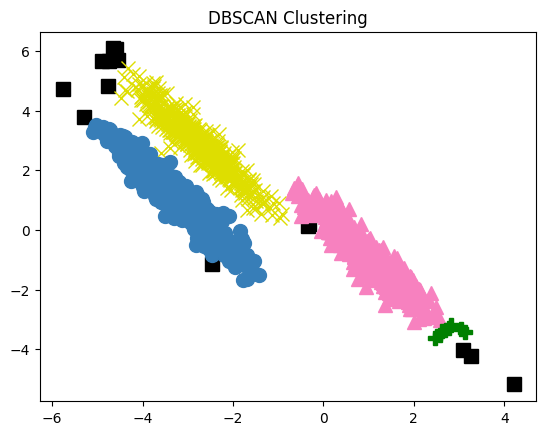

In [11]:
n_clusters_ = len(set(dbslabels)) - (1 if -1 in dbslabels else 0)
n_noise_ = list(dbslabels).count(-1)

import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf", ""]
markers = ["x", "o", "^", ""]

unique_labels = np.unique(dbslabels)
core_samples_mask = np.zeros_like(dbslabels, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True

for k in unique_labels:
    if k == -1:
        # Black used for noise.
        col = "#000000"
        markers = "s"
    elif k == 0:
        col = "#dede00"
        markers = "x"
    elif k == 1:
        col = "#377eb8"
        markers = "o"
    elif k == 2:
        col = "#f781bf"
        markers = "^"
    elif k == 3:
        col = "#008000"
        markers = "P"

    class_member_mask = dbslabels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        markers,
        markerfacecolor=col,
        markeredgecolor=col,
        markersize=10,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        markers,
        markerfacecolor=col,
        markeredgecolor=col,
        markersize=10,
    )

plt.title(f"DBSCAN Clustering")
plt.show()

A few too many outliers and also a 4th cluster (the green ones in the bottom right). We could tweak hyperparameters and improve. Instead let's build the pandas dataframe of mean values:

In [12]:
# add the data
df_dbs = pd.DataFrame(X, columns=['X1', 'X2'])
# add the labels
df_dbs['dbs_label'] = dbslabels

# Remove outliers
df_dbs_no_outliers = df_dbs[df_dbs['dbs_label'] != -1]

# Now we can use group_by to work out averages:
# group by label
df_dbs_grouped = df_dbs_no_outliers.groupby('dbs_label').mean()
df_dbs_grouped =  df_dbs_grouped.reset_index()
df_dbs_grouped


,dbs_label,X1,X2
0,0,-2.761356,2.890961
1,1,-3.189467,1.007900
2,2,0.961244,-0.816690
3,3,2.777414,-3.390211


Again, in the real-world compare these with the other two ("df\_km" and "df\_ward\_grouped") to see which makes most sense to you.

## Statistical Model Comparion
So far we have visualised results (only will work with lower dimensional problems) and compared the means. We could also look at some statistical measures.

### Silhouette Coefficient
The Silhouette Coefficient measures the degree measures how distinct the different clusters are. If we have very highly seperated clusters we would score towards the maximum (+1). If we have messed up the model enitrely we would score towards the minimum (-1). If we have a cluster model, but the clusters are overlapping we would score around 0. Ideally we want numbers between ~ 0.5-1.0.

Let's score each of the earlier models:

In [13]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for KMeans
silhouette_avg_km = silhouette_score(X, kmlabels)
print(f"Silhouette Score for KMeans: {silhouette_avg_km}")

# Calculate Silhouette Score for Ward
silhouette_avg_ward = silhouette_score(X, wardlabels)
print(f"Silhouette Score for Ward: {silhouette_avg_ward}")

# Calculate Silhouette Score for DBSCAN (excluding noise points)
dbs_no_noise = dbslabels != -1  # boolean mask for non-noise points

# we need to check the data isn't all outliers
if np.sum(dbs_no_noise) > 1 : # Check if enough non-noise points to calculate silhouette
  silhouette_avg_dbs = silhouette_score(X[dbs_no_noise], dbslabels[dbs_no_noise])
  print(f"Silhouette Score for DBSCAN: {silhouette_avg_dbs}")
else:
  print("Not enough non-noise points to calculate a meaningful silhouette score for DBSCAN")


Silhouette Score for KMeans: 0.5101812040360072
Silhouette Score for Ward: 0.47677153190376204
Silhouette Score for DBSCAN: 0.4129164911964734


For the earlier models, $K$-means scores highest at 0.51. DBSCAN scores lowest at 0.41. However, it is known that Silhouette will score convex clusters (the type built by $K$-means) higher, and density based clusters (built by DBSCAN) lower. It is a fair technique if we are comparing models of the same type - e.g. comparing one $K$-means model with another $K$-means model, but we need to account for this bias to convex clusters in our interpretation. Let's look at another metric as well.
<br><br>
### Calinski-Harabasz Index
CH Index is a measure of how much dispersion (spread-outness) there is within the cluster vs the disperson between each cluster. I.e. if there is a small amount of dispersion within a cluster (a tight/dense group of data), and there is significant dispersion between clusters (i.e. clusters are quite different) we have a good cluster model ... which is what the index rewards. More formally, it is the ratio of the dispersion between each cluster centroid and the global centroid, and the dispersion for each assigned point and its cluster centroid (where dispersion is defined as the sum of distances squared - i.e. $L2$). Let's get the scores:

In [14]:
from sklearn.metrics import calinski_harabasz_score

# Calculate Calinski-Harabasz Index for KMeans
ch_km = calinski_harabasz_score(X, kmlabels)
print(f"Calinski-Harabasz Index for KMeans: {ch_km}")

# Calculate Calinski-Harabasz Index for Ward
ch_ward = calinski_harabasz_score(X, wardlabels)
print(f"Calinski-Harabasz Index for Ward: {ch_ward}")

# Calculate Calinski-Harabasz Index for DBSCAN (excluding noise points)
if np.sum(dbs_no_noise) > 1 : # Check if enough non-noise points to calculate score
  ch_dbs = calinski_harabasz_score(X[dbs_no_noise], dbslabels[dbs_no_noise])
  print(f"Calinski-Harabasz Index for DBSCAN: {ch_dbs}")
else:
  print("Not enough non-noise points to calculate a meaningful Calinski-Harabasz score for DBSCAN")


Calinski-Harabasz Index for KMeans: 3716.5007263160696
Calinski-Harabasz Index for Ward: 3160.7855142918206
Calinski-Harabasz Index for DBSCAN: 2021.5856708724377


Again, this will be higher for convex cluster ($K$-means) than density based (DBSCAN) and usually more so than Silhouette Score. However, again we can see the score is higher (higher is good) for $K$-means and we would probably conclude this has worked best in this case. (However, we could tune our Hierarchical and DBSCAN model hyperparameters and this may potentially change).

### Selecting Hyperparameters
Using these same metrics we can tune our models to select the right hyperparameters. We'll start with $K$-means where, of course, the main hyperparameter is $K$:

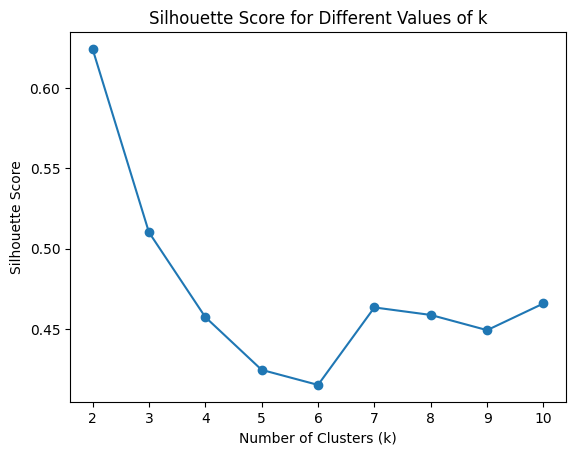

In [15]:
k_values = range(2, 11)  # Test k values from 1 to 10
silhouette_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.show()

When interpreting the results, we need to remember the essential trade-off in cluster analysis between a value too small to represent our data well, and also adding too many clusters and making our later tasks harder (e.g. increasing marketing spend). We tend to want to find the point in the graph that has the deepest descent (drops the most). In this case that would be $K$=2.

We could well conclude $K$=2 is the best result (highest score), however, we may also decide the two clusters is too few. We could also say that $K$=7 or $K$=10 may be attractive (as the score rises again here). But again, we may conclude that this is too many clusters.

Probably the viable values are 2, 3, 4, 7 and 10. From here the "best" would probably be a business decision!

For completeness let's try this for DBSCAN and $ϵ$:

Not enough clusters to calculate silhouette score for eps=0.5. Number of clusters: 1
Not enough clusters to calculate silhouette score for eps=0.6. Number of clusters: 1
Not enough clusters to calculate silhouette score for eps=0.7. Number of clusters: 1


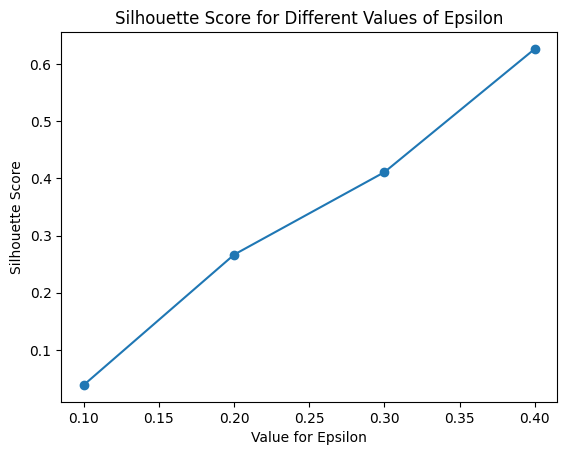

In [16]:
e_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # Test epsilon values

silhouette_scores = []

for e in e_values:
    dbs = DBSCAN(eps=e) # Changed k to e to use the current epsilon value
    cluster_labels = dbs.fit_predict(X)

    # Filter X and cluster_labels to exclude outliers before calculating silhouette score
    dbs_no_noise = cluster_labels != -1

    # Check if there are at least 2 unique labels (excluding -1 for noise) to calculate the silhouette score
    # This ensures that there are at least 2 clusters to compare.
    n_clusters = len(set(cluster_labels[dbs_no_noise]))

    if n_clusters >= 2:  # Check if enough clusters for silhouette score
        silhouette_avg = silhouette_score(X[dbs_no_noise], cluster_labels[dbs_no_noise])
        silhouette_scores.append(silhouette_avg)
    else:
        print(f"Not enough clusters to calculate silhouette score for eps={e}. Number of clusters: {n_clusters}")
        silhouette_scores.append(np.nan) # Append NaN to keep list size consistent


plt.plot(e_values, silhouette_scores, marker='o')
plt.xlabel('Value for Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of Epsilon')
plt.show()

Generally the results suggest 0.4 as the best value. As our numbers get higher (0.5 and beyond) the solution it finds is just one big cluster with everything else as outliers). I.e. the distance threshold is too high to find the clusters.

## EXERCISE (optional)
Try to follow these steps for the [HDBSCAN algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN). Note, you do not need to set the value for $ϵ$. How does it compare?